ライブラリのインポート

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
import copy
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet

パスの設定

In [84]:
# Train Data
train_data_pass = '../data/raw_data/train.csv'

# Test Data
test_data_pass = '../data/raw_data/test.csv'

データの確認

In [85]:
# Train dataの読み込み
df_train = pd.read_csv(train_data_pass, parse_dates=['datetime'])

# 'datetime'列をdatetime型に変換
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

# 指定位置に年，月，日，時間の列を挿入
df_train.insert(1, 'year', df_train['datetime'].dt.year)
df_train.insert(2, 'month', df_train['datetime'].dt.month)
df_train.insert(3, 'day', df_train['datetime'].dt.day)
df_train.insert(4, 'hour', df_train['datetime'].dt.hour)

# 結果を表示
df_train

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,2011,1,1,2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,2011,1,1,3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,2011,1,1,4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,2012,12,19,19,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,2012,12,19,20,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,2012,12,19,21,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,2012,12,19,22,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [86]:
# Test dataの読み込み
df_test = pd.read_csv(test_data_pass, parse_dates=['datetime'])

# 'datetime'列をdatetime型に変換
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# 指定位置に年，月，日，時間の列を挿入
df_test.insert(1, 'year', df_test['datetime'].dt.year)
df_test.insert(2, 'month', df_test['datetime'].dt.month)
df_test.insert(3, 'day', df_test['datetime'].dt.day)
df_test.insert(4, 'hour', df_test['datetime'].dt.hour)

# 結果を表示
df_test

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,2011,1,20,0,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,2011,1,20,1,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,2011,1,20,2,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,2011,1,20,3,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,2011,1,20,4,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,2012,12,31,19,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,2012,12,31,20,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,2012,12,31,21,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,2012,12,31,22,1,0,1,1,10.66,13.635,56,8.9981


Train Dataをcasualとregisteredにデータを分割

In [87]:
# 指定されたカラムのみを抽出
df_train_casual = df_train[['datetime', 'year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual']]
df_train_registered = df_train[['datetime', 'year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'registered']]
df_train_count = df_train[['datetime', 'year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'count']]

print("df_train_casual")
display(df_train_casual.head(2))

print("df_train_registered")
display(df_train_registered.head(2))

print("df_train_count")
display(df_train_count.head(2))

df_train_casual


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,3
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,8


df_train_registered


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,13
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,32


df_train_count


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,9.02,13.635,80,0.0,40


評価関数RMSLEとLightGBMの定義

In [88]:
# RandomForestモデル（デフォルト設定）
RF_casual_model = RandomForestRegressor(random_state=42)
RF_registered_model = RandomForestRegressor(random_state=42)

# LightGBMモデル（デフォルト設定）
LGB_casual_model = LGBMRegressor(random_state=42, verbosity=-1)
LGB_registered_model = LGBMRegressor(random_state=42, verbosity=-1)


# RMSLE評価関数
def evaluate_model_rmsle(y_true, y_pred):
    y_pred = np.where(y_pred < 0, 0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# 学習と評価
def train_and_evaluate_model(data, model, drop_column=[], tranlate_log=False):
    # 最終列をターゲット列として自動取得
    target_column = data.columns[-1]

    # 1日から18日を訓練データ、19日を検証データに指定
    train_data = data[data['day'] <= 18]
    valid_data = data[data['day'] == 19]

    # 訓練と検証のデータから指定された列を削除
    X_train, X_valid = train_data.drop(columns=["datetime", target_column] + drop_column), valid_data.drop(columns=["datetime", target_column] + drop_column)
    y_train, y_valid = train_data[target_column], valid_data[target_column]

    # モデルの学習
    model_fold = copy.deepcopy(model)
    if tranlate_log:
        model_fold.fit(X_train, np.log1p(y_train))
    else:
        model_fold.fit(X_train, y_train)

    # validデータに対する評価
    y_pred = model_fold.predict(X_valid)
    if tranlate_log:
        rmsle = evaluate_model_rmsle(y_valid, np.expm1(y_pred))
        y_pred = np.expm1(y_pred)  # 出力を元に戻す
    else:
        rmsle = evaluate_model_rmsle(y_valid, y_pred)

    print(f"{target_column.capitalize()} Prediction - RMSLE: {rmsle:.3f}")
    return model_fold, rmsle, y_pred

# Prophet用学習関数
def train_and_evaluate_prophet(data, target_column):
    # 説明変数を自動的に取得
    regressors = [col for col in data.columns if col not in ["datetime", target_column]]
    
    print(f"Using the following regressors: {regressors}")

    # データをProphetの形式に変換
    data = data.rename(columns={"datetime": "ds", target_column: "y"})
    
    # 訓練データと検証データを分割
    train_data = data[(data['day'] <= 18)]
    valid_data = data[(data['day'] == 19) & (data['year'] == 2012) & (data['month'] == 12)]

    # Prophetモデルの作成
    prophet_model = Prophet()
    #prophet_model.add_seasonality(name='hourly', period=24, fourier_order=10)
    for regressor in regressors:
        prophet_model.add_regressor(regressor)

    # モデルの学習
    prophet_model.fit(train_data[["ds"] + regressors + ["y"]])

    # 検証データの予測
    future = valid_data[["ds"] + regressors]
    forecast = prophet_model.predict(future)

    # 予測値とRMSLEの計算
    y_pred = forecast['yhat'].clip(lower=0)  # マイナスの予測値を0にクリップ

    rmsle = evaluate_model_rmsle(valid_data["y"], y_pred)

    print(f"{target_column.capitalize()} Prediction - RMSLE: {rmsle:.3f}")
    return prophet_model, rmsle, y_pred


# Count RMSLEの計算
def count_combined_rmsle(casual_pred, registered_pred, df_train_count, model_name, plot=True):
    # casualとregisteredの予測値を合算
    y_count_pred = casual_pred + registered_pred

    # テストデータのcount列（19日分）
    y_count_true = df_train_count[df_train_count['day'] == 19][['hour', 'count']]

    # 時間単位で集計（平均を計算）
    y_count_true_hourly = y_count_true.groupby('hour').mean()
    df_pred = pd.DataFrame({'hour': df_train_count[df_train_count['day'] == 19]['hour'], 'predicted_count': y_count_pred})
    y_count_pred_hourly = df_pred.groupby('hour').mean()
    
    # RMSLEの計算
    count_rmsle = evaluate_model_rmsle(y_count_true['count'], y_count_pred)
    print(f"\nCount Prediction - RMSLE: {count_rmsle:.3f}")

    # plotting
    if plot:
        plot_hourly_count_predictions(
            true_count=y_count_true_hourly['count'],
            predicted_count=y_count_pred_hourly['predicted_count'],
            model_name=model_name
        )

    return count_rmsle

# Count RMSLEの計算
def count_combined_rmsle_prophet(casual_pred, registered_pred, df_train_count, model_name, plot=True):
    # casualとregisteredの予測値を合算
    y_count_pred = casual_pred + registered_pred

    # テストデータのcount列（19日分）
    y_count_true = df_train_count[
        (df_train_count['day'] == 19) &
        (df_train_count['year'] == 2012) &
        (df_train_count['month'] == 12)
    ][['hour', 'count']].reset_index(drop=True)


    # 時間単位で集計（平均を計算）
    y_count_true_hourly = y_count_true.groupby('hour').mean()
    df_pred = pd.DataFrame({
        'hour': y_count_true['hour'],  # y_count_true から直接取得
        'predicted_count': y_count_pred
    })
    y_count_pred_hourly = df_pred.groupby('hour').mean()
    
    # RMSLEの計算
    count_rmsle = evaluate_model_rmsle(y_count_true['count'], y_count_pred)
    print(f"\nCount Prediction - RMSLE: {count_rmsle:.3f}")

    # plotting
    if plot:
        plot_hourly_count_predictions(
            true_count=y_count_true_hourly['count'],
            predicted_count=y_count_pred_hourly['predicted_count'],
            model_name=model_name
        )

    return count_rmsle

# 時間単位のプロット関数
def plot_hourly_count_predictions(true_count, predicted_count, model_name):
    plt.figure(figsize=(12, 3))
    plt.plot(true_count.index, true_count, label="True Count")
    plt.plot(predicted_count.index, predicted_count, label="Predicted Count")
    # plt.title(model_name)
    plt.xlabel("Hour")
    plt.ylabel("Average Count")
    plt.xticks(range(0, 24))  # 時間の範囲（0~23時）
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

学習

Training Casual Model
Casual Prediction - RMSLE: 0.617

Training Registered Model
Registered Prediction - RMSLE: 0.318

Count Prediction - RMSLE: 0.346


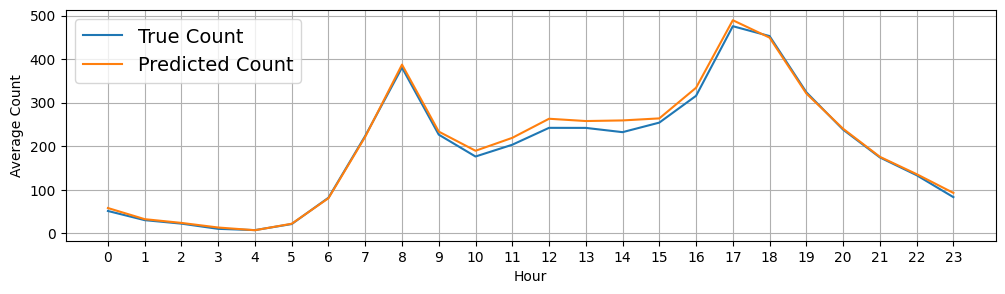

In [89]:
# RandomForest

# 学習と評価の実行
print("Training Casual Model")
RF_casual_model_trained, RF_casual_rmsle, RF_casual_pred = train_and_evaluate_model(df_train_casual, RF_casual_model)

print("\nTraining Registered Model")
RF_registered_model_trained, RF_registered_rmsle, RF_registered_pred = train_and_evaluate_model(df_train_registered, RF_registered_model)

# 合算したcountのRMSLEを計算
combined_rmsle = count_combined_rmsle(RF_casual_pred, RF_registered_pred, df_train_count, "RandomForest")

Training Casual Model
Casual Prediction - RMSLE: 0.601

Training Registered Model
Registered Prediction - RMSLE: 0.419

Count Prediction - RMSLE: 0.419


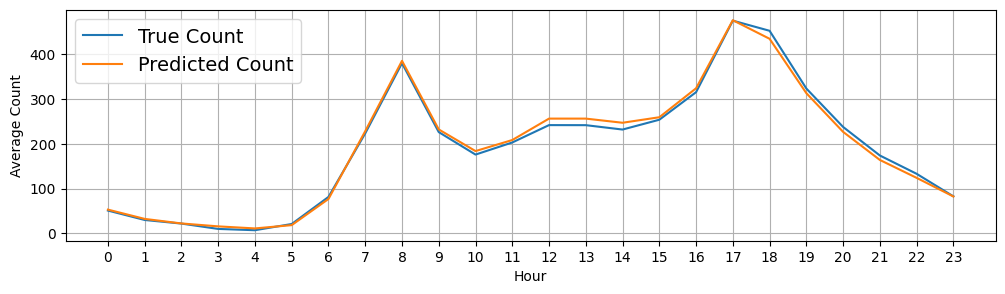

In [90]:
# LightGBM

# 学習と評価の実行
print("Training Casual Model")
LGB_casual_model_trained, LGB_casual_rmsle, LGB_casual_pred = train_and_evaluate_model(df_train_casual, LGB_casual_model)

print("\nTraining Registered Model")
LGB_registered_model_trained, LGB_registered_rmsle, LGB_registered_pred = train_and_evaluate_model(df_train_registered, LGB_registered_model)

# 合算したcountのRMSLEを計算
combined_rmsle = count_combined_rmsle(LGB_casual_pred, LGB_registered_pred, df_train_count, "LightGBM")

Training Casual Model
Using the following regressors: ['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


16:21:32 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing


Casual Prediction - RMSLE: 1.035

Training Registered Model
Using the following regressors: ['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


16:21:34 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing


Registered Prediction - RMSLE: 1.162

Count Prediction - RMSLE: 1.102


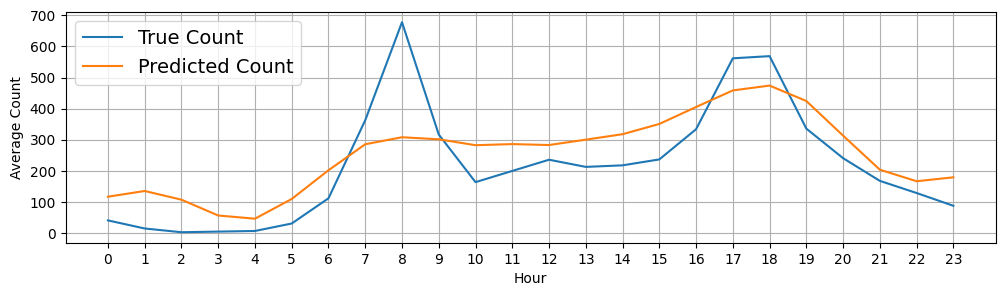

In [91]:
# Prophet

# 学習と評価の実行
print("Training Casual Model")
Prophet_casual_model_trained, Prophet_casual_rmsle, Prophet_casual_pred = train_and_evaluate_prophet(df_train_casual, "casual")

print("\nTraining Registered Model")
Prophet_registered_model_trained, Prophet_registered_rmsle, Prophet_registered_pred = train_and_evaluate_prophet(df_train_registered, "registered")

# 合算したcountのRMSLEを計算
combined_rmsle_prophet = count_combined_rmsle_prophet(Prophet_casual_pred, Prophet_registered_pred, df_train_count, "Prophet")

テストデータの予測

In [ ]:
def predict_test_data(saved_casual_model, saved_registered_model, test_data, drop_column=[], output_file="submission.csv", translate_log=False):

    # テストデータの特徴量を取得
    X_test = test_data.drop(columns=["datetime"] + drop_column)

    # `casual`と`registered`の予測
    if translate_log:
        casual_final_pred = np.expm1(saved_casual_model.predict(X_test))
        registered_final_pred = np.expm1(saved_registered_model.predict(X_test))
    else:
        casual_final_pred = saved_casual_model.predict(X_test)
        registered_final_pred = saved_registered_model.predict(X_test)

    # 負の値を0に変換
    casual_final_pred = np.maximum(0, casual_final_pred)
    registered_final_pred = np.maximum(0, registered_final_pred)

    # 合算して`count`を計算
    count_final_pred = casual_final_pred + registered_final_pred

    # 結果をDataFrameにまとめる
    submission_df = pd.DataFrame({
        "datetime": test_data["datetime"],
        "count": count_final_pred
    })

    # CSVとして保存
    submission_df.to_csv(output_file, index=False)
    print(f"Submission file saved as {output_file}")

In [ ]:
# テストデータの予測とCSV保存
predict_test_data(RF_casual_model_trained, RF_registered_model_trained, df_test, output_file="../out/submission-RF.csv")
predict_test_data(LGB_casual_model_trained, LGB_registered_model_trained, df_test, output_file="../out/submission-LGB.csv")